In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import copy
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import plotnine as gg
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:

def round_down(val, amt):
    return amt*math.floor(val/amt)

def round_up(val, amt):
    return amt*math.ceil(val/amt)

def intervals(xmin,xmax,spacing):
    return [xmin + spacing*i for i in range(int((xmax-xmin)/spacing)+1)]

def make_hist(a, bin_length):
    a_min = np.min(a)
    a_max = np.max(a)
    # round down bin length
    hist, edges = np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length))
    return hist, edges

def make_hist_from_std_dev(a,factor):
    s = np.std(a)
    bin_length = factor*s
    return make_hist(a, bin_length)

def make_hists(arrs, bin_length):
    a_min = np.min(arrs)
    a_max = np.max(arrs)
    # round down bin length
    li = [np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length)) for a in arrs]
    edges = li[0][1]
    hists = [t[0] for t in li] 
    return hists, edges

def make_hists_from_std_dev(arrs, factor):
    s = np.std(arrs[0])
    bin_length = factor*s
    return make_hists(arrs, bin_length)

def tv(a1,a2):
    return np.sum(np.abs((a1-a2).astype(float)))/(2*np.sum(a1))

#first array is ground truth
def merr(arrs, factor,verbosity=1):
    (num_arrs, sample_size, d) = arrs.shape
    tvs = np.zeros((num_arrs-1, d))
    hists_list = []
    for i in range(d):
        arr_i = arrs[:,:,i]
        hists, edges = make_hists_from_std_dev(arr_i, factor)
        printv(hists, verbosity,1)
        hists_list += [hists]
        for j in range(num_arrs-1):
            tvs[j,i] = tv(hists[0], hists[j+1])
    merrs = np.sum(tvs, axis=1)/d
    return tvs, merrs, hists
#def ma(true_samples, samples, side_length):

In [3]:
def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    print('SEED: %d' % seed)
    env = LogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets
def redraw_samples(agent, num, verbosity=1):
    samples = []
    #theta = agent.theta
    agent_copy = copy.deepcopy(agent)
    for i in range(num):
        printv("Drawing sample %d" % (i+1), verbosity, 1)
        #agent_copy.theta= theta
        s = agent_copy.get_sample()
        samples += [s]
        printv(" "+repr(s), verbosity, 2)
    return np.asarray(samples)
#def redraw_samples_sagald(agent, num, verbosity=1):
def redraw_samples_for_agents(agents, num, verbosity=1):
    samples_list = []

    for agent in agents:
        samples = redraw_samples(agent, num, verbosity)
        samples_list += [samples]
    samples_list = np.asarray(samples_list)
    return samples_list

In [4]:
num_articles = 1
dim = 1
var = 1.0
theta_mean = 0
theta_std = 1

time_limit= 0.1

verbosity=0

In [5]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda: BasicLangevinTS(num_articles, dim, [0]*(dim), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*(dim), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=99999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=False, context_has_constant=False, 
                                      n_steps=99999, time = time_limit, verbosity=verbosity)

SEED: 1
theta [1.62434536]
Experiment: Step 0


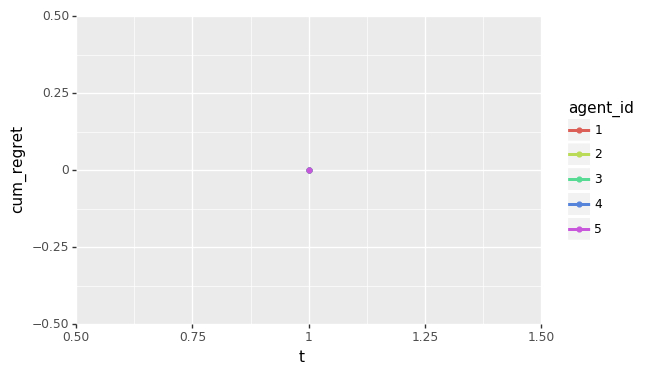

<ggplot: (8783212970869)>


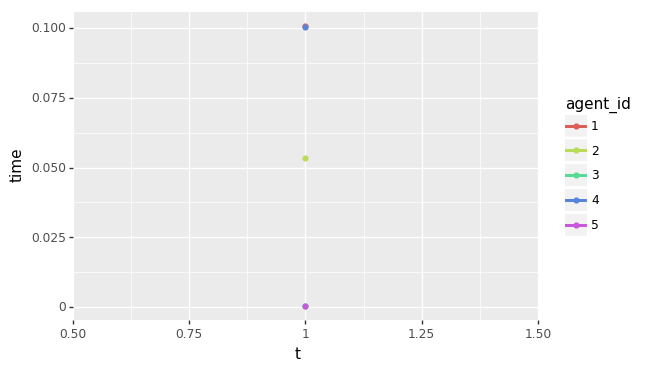

<ggplot: (8783212748181)>


([   action_id agent_id  cum_optimal  cum_regret  instant_regret  t      time  \
  0          1        1     0.933299         0.0             0.0  1  0.100771   
  1          2        2     0.933299         0.0             0.0  1  0.053468   
  2          3        3     0.933299         0.0             0.0  1  0.000373   
  3          4        4     0.933299         0.0             0.0  1  0.100417   
  4          5        5     0.933299         0.0             0.0  1  0.000554   
  
    unique_id  
  0      NULL  
  1      NULL  
  2      NULL  
  3      NULL  
  4      NULL  ],
    action_id agent_id  cum_optimal  cum_regret  instant_regret  t      time  \
 0          1        1     0.933299         0.0             0.0  1  0.100771   
 1          2        2     0.933299         0.0             0.0  1  0.053468   
 2          3        3     0.933299         0.0             0.0  1  0.000373   
 3          4        4     0.933299         0.0             0.0  1  0.100417   
 4          5

In [16]:
agents = [make_mala_agent(),
          make_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_sagald_agent()]
simple_compare(agents, num_articles, dim, var, 1, 1, verbosity=1)

In [17]:
samples_list = []
agents[0].v=1
agents[0].time=0
agents[0].n_steps=500
for agent in agents:
    samples = redraw_samples(agent, 1000, 2)
    samples_list += [samples]
samples_list = np.asarray(samples_list)

Drawing sample 1
 Sample: array([0.23032067])
 Accept proportion: 0.866000
 Steps taken: 500
 array([0.23032067])
Drawing sample 2
 Sample: array([-0.37266651])
 Accept proportion: 0.836000
 Steps taken: 500
 array([-0.37266651])
Drawing sample 3
 Sample: array([0.52607382])
 Accept proportion: 0.848000
 Steps taken: 500
 array([0.52607382])
Drawing sample 4
 Sample: array([-0.49761447])
 Accept proportion: 0.860000
 Steps taken: 500
 array([-0.49761447])
Drawing sample 5
 Sample: array([0.91766661])
 Accept proportion: 0.840000
 Steps taken: 500
 array([0.91766661])
Drawing sample 6
 Sample: array([0.88692027])
 Accept proportion: 0.870000
 Steps taken: 500
 array([0.88692027])
Drawing sample 7
 Sample: array([0.55586646])
 Accept proportion: 0.852000
 Steps taken: 500
 array([0.55586646])
Drawing sample 8
 Sample: array([1.63285271])
 Accept proportion: 0.872000
 Steps taken: 500
 array([1.63285271])
Drawing sample 9
 Sample: array([1.00920533])
 Accept proportion: 0.864000
 Steps ta

 Sample: array([0.50525457])
 Accept proportion: 0.880000
 Steps taken: 500
 array([0.50525457])
Drawing sample 75
 Sample: array([0.76488668])
 Accept proportion: 0.858000
 Steps taken: 500
 array([0.76488668])
Drawing sample 76
 Sample: array([-0.2607494])
 Accept proportion: 0.854000
 Steps taken: 500
 array([-0.2607494])
Drawing sample 77
 Sample: array([0.47684258])
 Accept proportion: 0.856000
 Steps taken: 500
 array([0.47684258])
Drawing sample 78
 Sample: array([0.4731959])
 Accept proportion: 0.866000
 Steps taken: 500
 array([0.4731959])
Drawing sample 79
 Sample: array([1.02047558])
 Accept proportion: 0.878000
 Steps taken: 500
 array([1.02047558])
Drawing sample 80
 Sample: array([0.37808714])
 Accept proportion: 0.868000
 Steps taken: 500
 array([0.37808714])
Drawing sample 81
 Sample: array([0.9404108])
 Accept proportion: 0.860000
 Steps taken: 500
 array([0.9404108])
Drawing sample 82
 Sample: array([0.32520016])
 Accept proportion: 0.888000
 Steps taken: 500
 array([

 Sample: array([0.50813302])
 Accept proportion: 0.882000
 Steps taken: 500
 array([0.50813302])
Drawing sample 147
 Sample: array([-0.35119671])
 Accept proportion: 0.866000
 Steps taken: 500
 array([-0.35119671])
Drawing sample 148
 Sample: array([0.56103307])
 Accept proportion: 0.890000
 Steps taken: 500
 array([0.56103307])
Drawing sample 149
 Sample: array([0.46744556])
 Accept proportion: 0.858000
 Steps taken: 500
 array([0.46744556])
Drawing sample 150
 Sample: array([0.6944526])
 Accept proportion: 0.872000
 Steps taken: 500
 array([0.6944526])
Drawing sample 151
 Sample: array([0.20199888])
 Accept proportion: 0.842000
 Steps taken: 500
 array([0.20199888])
Drawing sample 152
 Sample: array([0.10437649])
 Accept proportion: 0.858000
 Steps taken: 500
 array([0.10437649])
Drawing sample 153
 Sample: array([0.97240396])
 Accept proportion: 0.862000
 Steps taken: 500
 array([0.97240396])
Drawing sample 154
 Sample: array([-0.09007336])
 Accept proportion: 0.864000
 Steps taken:

 Sample: array([0.52850392])
 Accept proportion: 0.860000
 Steps taken: 500
 array([0.52850392])
Drawing sample 219
 Sample: array([1.23515491])
 Accept proportion: 0.898000
 Steps taken: 500
 array([1.23515491])
Drawing sample 220
 Sample: array([0.73477587])
 Accept proportion: 0.878000
 Steps taken: 500
 array([0.73477587])
Drawing sample 221
 Sample: array([-0.12758149])
 Accept proportion: 0.870000
 Steps taken: 500
 array([-0.12758149])
Drawing sample 222
 Sample: array([0.4256616])
 Accept proportion: 0.828000
 Steps taken: 500
 array([0.4256616])
Drawing sample 223
 Sample: array([0.67167019])
 Accept proportion: 0.884000
 Steps taken: 500
 array([0.67167019])
Drawing sample 224
 Sample: array([0.64832138])
 Accept proportion: 0.876000
 Steps taken: 500
 array([0.64832138])
Drawing sample 225
 Sample: array([0.89645451])
 Accept proportion: 0.856000
 Steps taken: 500
 array([0.89645451])
Drawing sample 226
 Sample: array([0.10862737])
 Accept proportion: 0.864000
 Steps taken: 

 Sample: array([-0.05983726])
 Accept proportion: 0.860000
 Steps taken: 500
 array([-0.05983726])
Drawing sample 291
 Sample: array([-0.2026172])
 Accept proportion: 0.864000
 Steps taken: 500
 array([-0.2026172])
Drawing sample 292
 Sample: array([0.80586354])
 Accept proportion: 0.878000
 Steps taken: 500
 array([0.80586354])
Drawing sample 293
 Sample: array([0.49220233])
 Accept proportion: 0.892000
 Steps taken: 500
 array([0.49220233])
Drawing sample 294
 Sample: array([0.67677891])
 Accept proportion: 0.858000
 Steps taken: 500
 array([0.67677891])
Drawing sample 295
 Sample: array([0.98342553])
 Accept proportion: 0.892000
 Steps taken: 500
 array([0.98342553])
Drawing sample 296
 Sample: array([0.39123009])
 Accept proportion: 0.862000
 Steps taken: 500
 array([0.39123009])
Drawing sample 297
 Sample: array([-0.40179356])
 Accept proportion: 0.874000
 Steps taken: 500
 array([-0.40179356])
Drawing sample 298
 Sample: array([0.90049086])
 Accept proportion: 0.884000
 Steps tak

 Sample: array([0.74972439])
 Accept proportion: 0.864000
 Steps taken: 500
 array([0.74972439])
Drawing sample 363
 Sample: array([-0.24997891])
 Accept proportion: 0.832000
 Steps taken: 500
 array([-0.24997891])
Drawing sample 364
 Sample: array([-0.00291909])
 Accept proportion: 0.862000
 Steps taken: 500
 array([-0.00291909])
Drawing sample 365
 Sample: array([-0.39938822])
 Accept proportion: 0.826000
 Steps taken: 500
 array([-0.39938822])
Drawing sample 366
 Sample: array([0.65050258])
 Accept proportion: 0.892000
 Steps taken: 500
 array([0.65050258])
Drawing sample 367
 Sample: array([1.23372976])
 Accept proportion: 0.860000
 Steps taken: 500
 array([1.23372976])
Drawing sample 368
 Sample: array([0.94991432])
 Accept proportion: 0.840000
 Steps taken: 500
 array([0.94991432])
Drawing sample 369
 Sample: array([0.21264407])
 Accept proportion: 0.866000
 Steps taken: 500
 array([0.21264407])
Drawing sample 370
 Sample: array([0.47115078])
 Accept proportion: 0.860000
 Steps t

 Sample: array([1.62635718])
 Accept proportion: 0.862000
 Steps taken: 500
 array([1.62635718])
Drawing sample 435
 Sample: array([0.49846644])
 Accept proportion: 0.856000
 Steps taken: 500
 array([0.49846644])
Drawing sample 436
 Sample: array([1.25066699])
 Accept proportion: 0.876000
 Steps taken: 500
 array([1.25066699])
Drawing sample 437
 Sample: array([0.4058581])
 Accept proportion: 0.860000
 Steps taken: 500
 array([0.4058581])
Drawing sample 438
 Sample: array([0.66997855])
 Accept proportion: 0.850000
 Steps taken: 500
 array([0.66997855])
Drawing sample 439
 Sample: array([0.61353537])
 Accept proportion: 0.860000
 Steps taken: 500
 array([0.61353537])
Drawing sample 440
 Sample: array([0.93269287])
 Accept proportion: 0.838000
 Steps taken: 500
 array([0.93269287])
Drawing sample 441
 Sample: array([-0.27980346])
 Accept proportion: 0.848000
 Steps taken: 500
 array([-0.27980346])
Drawing sample 442
 Sample: array([-0.10612391])
 Accept proportion: 0.864000
 Steps taken:

 Sample: array([0.35418983])
 Accept proportion: 0.824000
 Steps taken: 500
 array([0.35418983])
Drawing sample 507
 Sample: array([0.03518405])
 Accept proportion: 0.856000
 Steps taken: 500
 array([0.03518405])
Drawing sample 508
 Sample: array([0.17949209])
 Accept proportion: 0.862000
 Steps taken: 500
 array([0.17949209])
Drawing sample 509
 Sample: array([0.58395103])
 Accept proportion: 0.854000
 Steps taken: 500
 array([0.58395103])
Drawing sample 510
 Sample: array([1.01208219])
 Accept proportion: 0.838000
 Steps taken: 500
 array([1.01208219])
Drawing sample 511
 Sample: array([0.89438801])
 Accept proportion: 0.860000
 Steps taken: 500
 array([0.89438801])
Drawing sample 512
 Sample: array([-0.3519801])
 Accept proportion: 0.844000
 Steps taken: 500
 array([-0.3519801])
Drawing sample 513
 Sample: array([0.15289777])
 Accept proportion: 0.890000
 Steps taken: 500
 array([0.15289777])
Drawing sample 514
 Sample: array([1.15451168])
 Accept proportion: 0.890000
 Steps taken: 

 Sample: array([0.5303435])
 Accept proportion: 0.902000
 Steps taken: 500
 array([0.5303435])
Drawing sample 579
 Sample: array([0.22020378])
 Accept proportion: 0.868000
 Steps taken: 500
 array([0.22020378])
Drawing sample 580
 Sample: array([0.31007514])
 Accept proportion: 0.866000
 Steps taken: 500
 array([0.31007514])
Drawing sample 581
 Sample: array([0.33612682])
 Accept proportion: 0.864000
 Steps taken: 500
 array([0.33612682])
Drawing sample 582
 Sample: array([0.8311206])
 Accept proportion: 0.874000
 Steps taken: 500
 array([0.8311206])
Drawing sample 583
 Sample: array([0.56093841])
 Accept proportion: 0.856000
 Steps taken: 500
 array([0.56093841])
Drawing sample 584
 Sample: array([0.99150329])
 Accept proportion: 0.854000
 Steps taken: 500
 array([0.99150329])
Drawing sample 585
 Sample: array([0.75192301])
 Accept proportion: 0.848000
 Steps taken: 500
 array([0.75192301])
Drawing sample 586
 Sample: array([0.51409011])
 Accept proportion: 0.848000
 Steps taken: 500


 Sample: array([0.5664796])
 Accept proportion: 0.852000
 Steps taken: 500
 array([0.5664796])
Drawing sample 651
 Sample: array([-0.11993178])
 Accept proportion: 0.848000
 Steps taken: 500
 array([-0.11993178])
Drawing sample 652
 Sample: array([0.31917904])
 Accept proportion: 0.882000
 Steps taken: 500
 array([0.31917904])
Drawing sample 653
 Sample: array([0.5924044])
 Accept proportion: 0.878000
 Steps taken: 500
 array([0.5924044])
Drawing sample 654
 Sample: array([-0.01848301])
 Accept proportion: 0.890000
 Steps taken: 500
 array([-0.01848301])
Drawing sample 655
 Sample: array([-0.31252673])
 Accept proportion: 0.854000
 Steps taken: 500
 array([-0.31252673])
Drawing sample 656
 Sample: array([1.33618285])
 Accept proportion: 0.872000
 Steps taken: 500
 array([1.33618285])
Drawing sample 657
 Sample: array([1.5140274])
 Accept proportion: 0.794000
 Steps taken: 500
 array([1.5140274])
Drawing sample 658
 Sample: array([0.18606009])
 Accept proportion: 0.856000
 Steps taken: 

 Sample: array([0.05497789])
 Accept proportion: 0.836000
 Steps taken: 500
 array([0.05497789])
Drawing sample 723
 Sample: array([0.51644903])
 Accept proportion: 0.852000
 Steps taken: 500
 array([0.51644903])
Drawing sample 724
 Sample: array([-0.2056403])
 Accept proportion: 0.858000
 Steps taken: 500
 array([-0.2056403])
Drawing sample 725
 Sample: array([0.62574799])
 Accept proportion: 0.880000
 Steps taken: 500
 array([0.62574799])
Drawing sample 726
 Sample: array([0.57464988])
 Accept proportion: 0.868000
 Steps taken: 500
 array([0.57464988])
Drawing sample 727
 Sample: array([0.13000136])
 Accept proportion: 0.848000
 Steps taken: 500
 array([0.13000136])
Drawing sample 728
 Sample: array([0.91682544])
 Accept proportion: 0.882000
 Steps taken: 500
 array([0.91682544])
Drawing sample 729
 Sample: array([1.01895104])
 Accept proportion: 0.862000
 Steps taken: 500
 array([1.01895104])
Drawing sample 730
 Sample: array([0.57023449])
 Accept proportion: 0.852000
 Steps taken: 

 Sample: array([-0.10469771])
 Accept proportion: 0.814000
 Steps taken: 500
 array([-0.10469771])
Drawing sample 795
 Sample: array([0.31582617])
 Accept proportion: 0.850000
 Steps taken: 500
 array([0.31582617])
Drawing sample 796
 Sample: array([0.90215497])
 Accept proportion: 0.892000
 Steps taken: 500
 array([0.90215497])
Drawing sample 797
 Sample: array([0.37753542])
 Accept proportion: 0.852000
 Steps taken: 500
 array([0.37753542])
Drawing sample 798
 Sample: array([-0.09379256])
 Accept proportion: 0.900000
 Steps taken: 500
 array([-0.09379256])
Drawing sample 799
 Sample: array([0.89555674])
 Accept proportion: 0.880000
 Steps taken: 500
 array([0.89555674])
Drawing sample 800
 Sample: array([0.80687463])
 Accept proportion: 0.886000
 Steps taken: 500
 array([0.80687463])
Drawing sample 801
 Sample: array([0.6338857])
 Accept proportion: 0.872000
 Steps taken: 500
 array([0.6338857])
Drawing sample 802
 Sample: array([0.46559889])
 Accept proportion: 0.874000
 Steps taken

 Sample: array([0.40699176])
 Accept proportion: 0.836000
 Steps taken: 500
 array([0.40699176])
Drawing sample 867
 Sample: array([1.23060471])
 Accept proportion: 0.866000
 Steps taken: 500
 array([1.23060471])
Drawing sample 868
 Sample: array([0.44868511])
 Accept proportion: 0.868000
 Steps taken: 500
 array([0.44868511])
Drawing sample 869
 Sample: array([0.61947952])
 Accept proportion: 0.866000
 Steps taken: 500
 array([0.61947952])
Drawing sample 870
 Sample: array([0.68358103])
 Accept proportion: 0.846000
 Steps taken: 500
 array([0.68358103])
Drawing sample 871
 Sample: array([0.0323474])
 Accept proportion: 0.856000
 Steps taken: 500
 array([0.0323474])
Drawing sample 872
 Sample: array([0.27910622])
 Accept proportion: 0.858000
 Steps taken: 500
 array([0.27910622])
Drawing sample 873
 Sample: array([1.12307953])
 Accept proportion: 0.874000
 Steps taken: 500
 array([1.12307953])
Drawing sample 874
 Sample: array([-0.0390143])
 Accept proportion: 0.854000
 Steps taken: 50

 Sample: array([0.83618084])
 Accept proportion: 0.830000
 Steps taken: 500
 array([0.83618084])
Drawing sample 939
 Sample: array([0.39916967])
 Accept proportion: 0.868000
 Steps taken: 500
 array([0.39916967])
Drawing sample 940
 Sample: array([0.64102437])
 Accept proportion: 0.878000
 Steps taken: 500
 array([0.64102437])
Drawing sample 941
 Sample: array([0.43992643])
 Accept proportion: 0.864000
 Steps taken: 500
 array([0.43992643])
Drawing sample 942
 Sample: array([1.0418523])
 Accept proportion: 0.846000
 Steps taken: 500
 array([1.0418523])
Drawing sample 943
 Sample: array([0.59232556])
 Accept proportion: 0.856000
 Steps taken: 500
 array([0.59232556])
Drawing sample 944
 Sample: array([0.02636017])
 Accept proportion: 0.854000
 Steps taken: 500
 array([0.02636017])
Drawing sample 945
 Sample: array([-0.28314995])
 Accept proportion: 0.848000
 Steps taken: 500
 array([-0.28314995])
Drawing sample 946
 Sample: array([0.51424942])
 Accept proportion: 0.864000
 Steps taken: 

Drawing sample 52
 array([4.20388537])
Drawing sample 53
 array([4.35906081])
Drawing sample 54
 array([5.06520881])
Drawing sample 55
 array([3.9301866])
Drawing sample 56
 array([1.21913701])
Drawing sample 57
 array([2.60083078])
Drawing sample 58
 array([3.27883827])
Drawing sample 59
 array([4.04584043])
Drawing sample 60
 array([2.52076586])
Drawing sample 61
 array([2.18786013])
Drawing sample 62
 array([2.22799054])
Drawing sample 63
 array([3.37123048])
Drawing sample 64
 array([2.68762968])
Drawing sample 65
 array([4.56516472])
Drawing sample 66
 array([3.46732355])
Drawing sample 67
 array([1.99294952])
Drawing sample 68
 array([2.0133827])
Drawing sample 69
 array([2.51735971])
Drawing sample 70
 array([3.59679227])
Drawing sample 71
 array([3.56593696])
Drawing sample 72
 array([3.95193255])
Drawing sample 73
 array([2.77617248])
Drawing sample 74
 array([2.8558531])
Drawing sample 75
 array([3.54241224])
Drawing sample 76
 array([2.08413332])
Drawing sample 77
 array([3.

 array([4.84162525])
Drawing sample 419
 array([3.17783303])
Drawing sample 420
 array([5.04773286])
Drawing sample 421
 array([2.24283954])
Drawing sample 422
 array([2.94231972])
Drawing sample 423
 array([2.90008077])
Drawing sample 424
 array([1.43130673])
Drawing sample 425
 array([2.55772543])
Drawing sample 426
 array([1.53199983])
Drawing sample 427
 array([3.02490192])
Drawing sample 428
 array([1.82752519])
Drawing sample 429
 array([0.58328505])
Drawing sample 430
 array([3.983827])
Drawing sample 431
 array([2.83252448])
Drawing sample 432
 array([3.23730702])
Drawing sample 433
 array([1.94275542])
Drawing sample 434
 array([3.90234641])
Drawing sample 435
 array([2.4501495])
Drawing sample 436
 array([4.86577676])
Drawing sample 437
 array([3.6666826])
Drawing sample 438
 array([2.28895441])
Drawing sample 439
 array([2.76574759])
Drawing sample 440
 array([4.55951732])
Drawing sample 441
 array([3.42859295])
Drawing sample 442
 array([4.49650311])
Drawing sample 443
 arr

 array([2.51098396])
Drawing sample 768
 array([2.62346516])
Drawing sample 769
 array([3.8777842])
Drawing sample 770
 array([2.00090061])
Drawing sample 771
 array([1.42260988])
Drawing sample 772
 array([2.49436849])
Drawing sample 773
 array([3.76990543])
Drawing sample 774
 array([2.82858632])
Drawing sample 775
 array([3.21359154])
Drawing sample 776
 array([2.90757311])
Drawing sample 777
 array([3.2663968])
Drawing sample 778
 array([2.1622424])
Drawing sample 779
 array([3.51970099])
Drawing sample 780
 array([3.82005767])
Drawing sample 781
 array([2.71783343])
Drawing sample 782
 array([4.80128533])
Drawing sample 783
 array([3.14395257])
Drawing sample 784
 array([5.76121747])
Drawing sample 785
 array([1.81176018])
Drawing sample 786
 array([2.28631186])
Drawing sample 787
 array([3.41001983])
Drawing sample 788
 array([4.21721838])
Drawing sample 789
 array([2.77614381])
Drawing sample 790
 array([4.13708955])
Drawing sample 791
 array([3.21131357])
Drawing sample 792
 ar

 array([-0.05622593])
Drawing sample 2
 array([-0.90907193])
Drawing sample 3
 array([-0.56167005])
Drawing sample 4
 array([1.27545861])
Drawing sample 5
 array([1.13145263])
Drawing sample 6
 array([0.41267511])
Drawing sample 7
 array([1.2422558])
Drawing sample 8
 array([-0.14343602])
Drawing sample 9
 array([-0.58699214])
Drawing sample 10
 array([0.19402563])
Drawing sample 11
 array([-0.70488655])
Drawing sample 12
 array([-0.75815155])
Drawing sample 13
 array([-0.38064204])
Drawing sample 14
 array([0.91360063])
Drawing sample 15
 array([-2.3729694])
Drawing sample 16
 array([-1.57211063])
Drawing sample 17
 array([1.6996456])
Drawing sample 18
 array([0.38499355])
Drawing sample 19
 array([-0.07543872])
Drawing sample 20
 array([0.42008829])
Drawing sample 21
 array([1.47763891])
Drawing sample 22
 array([0.73175086])
Drawing sample 23
 array([0.20669095])
Drawing sample 24
 array([-1.2779444])
Drawing sample 25
 array([0.90903657])
Drawing sample 26
 array([0.82671859])
Draw

 array([1.29936494])
Drawing sample 211
 array([-0.25601929])
Drawing sample 212
 array([0.37522241])
Drawing sample 213
 array([1.54769288])
Drawing sample 214
 array([1.22283068])
Drawing sample 215
 array([-0.05446755])
Drawing sample 216
 array([0.45372106])
Drawing sample 217
 array([0.50441798])
Drawing sample 218
 array([1.19898699])
Drawing sample 219
 array([0.87588368])
Drawing sample 220
 array([1.11411963])
Drawing sample 221
 array([0.67445141])
Drawing sample 222
 array([0.97758303])
Drawing sample 223
 array([1.16205235])
Drawing sample 224
 array([0.91034145])
Drawing sample 225
 array([0.55474997])
Drawing sample 226
 array([0.60835154])
Drawing sample 227
 array([-0.13256904])
Drawing sample 228
 array([-0.95086586])
Drawing sample 229
 array([1.45871773])
Drawing sample 230
 array([0.93822573])
Drawing sample 231
 array([1.09683277])
Drawing sample 232
 array([1.64068431])
Drawing sample 233
 array([0.06762278])
Drawing sample 234
 array([0.95910525])
Drawing sample 

 array([2.21562482])
Drawing sample 417
 array([0.36444569])
Drawing sample 418
 array([1.22853537])
Drawing sample 419
 array([1.1641589])
Drawing sample 420
 array([0.06309215])
Drawing sample 421
 array([-0.15225339])
Drawing sample 422
 array([0.27654126])
Drawing sample 423
 array([0.03920191])
Drawing sample 424
 array([0.73262716])
Drawing sample 425
 array([-0.87123491])
Drawing sample 426
 array([0.08138235])
Drawing sample 427
 array([-0.21822482])
Drawing sample 428
 array([-0.50799254])
Drawing sample 429
 array([2.74194395])
Drawing sample 430
 array([-0.30455973])
Drawing sample 431
 array([1.21367201])
Drawing sample 432
 array([0.38623004])
Drawing sample 433
 array([0.15694419])
Drawing sample 434
 array([1.34700151])
Drawing sample 435
 array([0.12675073])
Drawing sample 436
 array([-0.04606383])
Drawing sample 437
 array([2.24163133])
Drawing sample 438
 array([-0.4511616])
Drawing sample 439
 array([0.01531631])
Drawing sample 440
 array([1.98148363])
Drawing sample

 array([0.69577614])
Drawing sample 622
 array([-0.93303023])
Drawing sample 623
 array([-0.60444273])
Drawing sample 624
 array([-0.06497726])
Drawing sample 625
 array([1.21714806])
Drawing sample 626
 array([0.94612825])
Drawing sample 627
 array([1.84245245])
Drawing sample 628
 array([0.25605269])
Drawing sample 629
 array([-0.59123245])
Drawing sample 630
 array([1.44794444])
Drawing sample 631
 array([-0.25853832])
Drawing sample 632
 array([-1.62886172])
Drawing sample 633
 array([-0.85560036])
Drawing sample 634
 array([1.66307186])
Drawing sample 635
 array([1.24602178])
Drawing sample 636
 array([0.10240192])
Drawing sample 637
 array([0.71034174])
Drawing sample 638
 array([-0.02406589])
Drawing sample 639
 array([0.65750315])
Drawing sample 640
 array([0.03527121])
Drawing sample 641
 array([0.47994743])
Drawing sample 642
 array([1.75066459])
Drawing sample 643
 array([1.30457931])
Drawing sample 644
 array([0.01371367])
Drawing sample 645
 array([1.33722188])
Drawing sam

 array([-0.59316185])
Drawing sample 827
 array([0.22268085])
Drawing sample 828
 array([-0.56491])
Drawing sample 829
 array([-0.4335497])
Drawing sample 830
 array([0.55324131])
Drawing sample 831
 array([0.0273036])
Drawing sample 832
 array([1.05828477])
Drawing sample 833
 array([-0.77516746])
Drawing sample 834
 array([2.61307189])
Drawing sample 835
 array([0.90281931])
Drawing sample 836
 array([0.728912])
Drawing sample 837
 array([-0.50033946])
Drawing sample 838
 array([0.47953953])
Drawing sample 839
 array([-0.05454066])
Drawing sample 840
 array([0.31316346])
Drawing sample 841
 array([-0.01457433])
Drawing sample 842
 array([-0.31734488])
Drawing sample 843
 array([1.13382831])
Drawing sample 844
 array([0.41004855])
Drawing sample 845
 array([-0.44898874])
Drawing sample 846
 array([0.93015338])
Drawing sample 847
 array([0.43434431])
Drawing sample 848
 array([-0.34737299])
Drawing sample 849
 array([-0.06450414])
Drawing sample 850
 array([-0.36465209])
Drawing sample

 array([1.92711671])
Drawing sample 34
 array([0.21043105])
Drawing sample 35
 array([-0.2055644])
Drawing sample 36
 array([1.05701857])
Drawing sample 37
 array([0.69972749])
Drawing sample 38
 array([0.84689428])
Drawing sample 39
 array([1.31918119])
Drawing sample 40
 array([1.60109029])
Drawing sample 41
 array([-0.12643041])
Drawing sample 42
 array([1.39005872])
Drawing sample 43
 array([-0.58032826])
Drawing sample 44
 array([1.68075298])
Drawing sample 45
 array([1.41197148])
Drawing sample 46
 array([-0.33785607])
Drawing sample 47
 array([0.35940111])
Drawing sample 48
 array([0.7778645])
Drawing sample 49
 array([0.86802684])
Drawing sample 50
 array([2.0719765])
Drawing sample 51
 array([0.39791181])
Drawing sample 52
 array([0.42048788])
Drawing sample 53
 array([1.84700657])
Drawing sample 54
 array([-1.14852086])
Drawing sample 55
 array([1.43955128])
Drawing sample 56
 array([0.35511774])
Drawing sample 57
 array([0.56121515])
Drawing sample 58
 array([-0.27255583])
D

 array([0.77377045])
Drawing sample 241
 array([0.66606235])
Drawing sample 242
 array([-0.1341108])
Drawing sample 243
 array([2.38909523])
Drawing sample 244
 array([-0.374075])
Drawing sample 245
 array([-0.4362747])
Drawing sample 246
 array([-0.96088886])
Drawing sample 247
 array([1.21231294])
Drawing sample 248
 array([0.3472202])
Drawing sample 249
 array([0.02397783])
Drawing sample 250
 array([-0.21980575])
Drawing sample 251
 array([1.06681391])
Drawing sample 252
 array([-0.79765023])
Drawing sample 253
 array([0.44214359])
Drawing sample 254
 array([1.09939859])
Drawing sample 255
 array([0.227791])
Drawing sample 256
 array([2.25889546])
Drawing sample 257
 array([0.71957317])
Drawing sample 258
 array([0.07323155])
Drawing sample 259
 array([1.31757318])
Drawing sample 260
 array([0.66415758])
Drawing sample 261
 array([0.40082374])
Drawing sample 262
 array([0.37893621])
Drawing sample 263
 array([1.51178913])
Drawing sample 264
 array([0.24541073])
Drawing sample 265
 

 array([1.29667159])
Drawing sample 447
 array([1.08762447])
Drawing sample 448
 array([0.8358099])
Drawing sample 449
 array([-0.19003614])
Drawing sample 450
 array([0.84504882])
Drawing sample 451
 array([-0.37366633])
Drawing sample 452
 array([-0.02169771])
Drawing sample 453
 array([0.11992407])
Drawing sample 454
 array([-0.35685295])
Drawing sample 455
 array([-0.09952059])
Drawing sample 456
 array([1.53912347])
Drawing sample 457
 array([0.66807741])
Drawing sample 458
 array([-0.61811479])
Drawing sample 459
 array([1.10776329])
Drawing sample 460
 array([0.25442305])
Drawing sample 461
 array([0.77270807])
Drawing sample 462
 array([0.32896486])
Drawing sample 463
 array([1.50556544])
Drawing sample 464
 array([2.77319069])
Drawing sample 465
 array([-0.1237078])
Drawing sample 466
 array([-0.70091304])
Drawing sample 467
 array([1.15775212])
Drawing sample 468
 array([-0.04287958])
Drawing sample 469
 array([-0.90973164])
Drawing sample 470
 array([0.95220629])
Drawing sam

 array([0.39078361])
Drawing sample 652
 array([0.94747675])
Drawing sample 653
 array([-0.49661998])
Drawing sample 654
 array([1.21572388])
Drawing sample 655
 array([3.03794151])
Drawing sample 656
 array([-0.16511911])
Drawing sample 657
 array([0.05193101])
Drawing sample 658
 array([1.04685955])
Drawing sample 659
 array([1.1565691])
Drawing sample 660
 array([0.03062029])
Drawing sample 661
 array([-0.02199593])
Drawing sample 662
 array([0.84149187])
Drawing sample 663
 array([2.12656294])
Drawing sample 664
 array([1.23893981])
Drawing sample 665
 array([0.9043295])
Drawing sample 666
 array([1.07558374])
Drawing sample 667
 array([1.03327017])
Drawing sample 668
 array([1.89513592])
Drawing sample 669
 array([1.28048738])
Drawing sample 670
 array([1.68017386])
Drawing sample 671
 array([0.41934183])
Drawing sample 672
 array([0.1540287])
Drawing sample 673
 array([-0.23606996])
Drawing sample 674
 array([-0.46484511])
Drawing sample 675
 array([-0.13220368])
Drawing sample 6

 array([0.73601732])
Drawing sample 858
 array([0.30361708])
Drawing sample 859
 array([0.248129])
Drawing sample 860
 array([-0.97579282])
Drawing sample 861
 array([-0.90254506])
Drawing sample 862
 array([1.62687626])
Drawing sample 863
 array([0.74501741])
Drawing sample 864
 array([-0.61813944])
Drawing sample 865
 array([3.58453814])
Drawing sample 866
 array([1.19167234])
Drawing sample 867
 array([-1.04424194])
Drawing sample 868
 array([0.06033517])
Drawing sample 869
 array([0.21774296])
Drawing sample 870
 array([1.49685683])
Drawing sample 871
 array([-0.06906289])
Drawing sample 872
 array([-0.67211348])
Drawing sample 873
 array([1.267947])
Drawing sample 874
 array([0.37751695])
Drawing sample 875
 array([-0.64523919])
Drawing sample 876
 array([-0.45889213])
Drawing sample 877
 array([0.35015564])
Drawing sample 878
 array([1.70580479])
Drawing sample 879
 array([1.39823549])
Drawing sample 880
 array([-0.09812979])
Drawing sample 881
 array([0.09533576])
Drawing sample

 array([1.23625424])
Drawing sample 64
 array([0.48968274])
Drawing sample 65
 array([1.33363977])
Drawing sample 66
 array([-0.12637521])
Drawing sample 67
 array([-0.08312316])
Drawing sample 68
 array([1.02363903])
Drawing sample 69
 array([-0.56887494])
Drawing sample 70
 array([2.37069725])
Drawing sample 71
 array([1.98921709])
Drawing sample 72
 array([0.21307071])
Drawing sample 73
 array([1.74750302])
Drawing sample 74
 array([1.06593469])
Drawing sample 75
 array([0.12506958])
Drawing sample 76
 array([1.66313429])
Drawing sample 77
 array([0.70245482])
Drawing sample 78
 array([1.78203399])
Drawing sample 79
 array([1.25272883])
Drawing sample 80
 array([0.01555621])
Drawing sample 81
 array([0.6263343])
Drawing sample 82
 array([0.15711173])
Drawing sample 83
 array([1.65024436])
Drawing sample 84
 array([1.63255657])
Drawing sample 85
 array([1.63429335])
Drawing sample 86
 array([0.93526284])
Drawing sample 87
 array([0.31217299])
Drawing sample 88
 array([0.16407592])
Dr

 array([0.06129233])
Drawing sample 269
 array([0.52730727])
Drawing sample 270
 array([-0.08813903])
Drawing sample 271
 array([-0.24979667])
Drawing sample 272
 array([0.50416595])
Drawing sample 273
 array([0.33595469])
Drawing sample 274
 array([-0.15205795])
Drawing sample 275
 array([-1.23293402])
Drawing sample 276
 array([0.61780925])
Drawing sample 277
 array([1.01007821])
Drawing sample 278
 array([-0.379938])
Drawing sample 279
 array([1.71959489])
Drawing sample 280
 array([0.90082028])
Drawing sample 281
 array([1.42513765])
Drawing sample 282
 array([0.12210285])
Drawing sample 283
 array([0.47788749])
Drawing sample 284
 array([0.58999007])
Drawing sample 285
 array([1.28565377])
Drawing sample 286
 array([1.94159307])
Drawing sample 287
 array([1.99367979])
Drawing sample 288
 array([0.11457787])
Drawing sample 289
 array([0.8042901])
Drawing sample 290
 array([-0.33182545])
Drawing sample 291
 array([1.5055888])
Drawing sample 292
 array([0.46729068])
Drawing sample 29

 array([1.04305671])
Drawing sample 474
 array([-0.52956051])
Drawing sample 475
 array([0.78018286])
Drawing sample 476
 array([1.08876564])
Drawing sample 477
 array([-0.72936664])
Drawing sample 478
 array([0.48156317])
Drawing sample 479
 array([0.92101976])
Drawing sample 480
 array([-0.04691803])
Drawing sample 481
 array([0.41238672])
Drawing sample 482
 array([-0.59576444])
Drawing sample 483
 array([1.12895152])
Drawing sample 484
 array([0.64821031])
Drawing sample 485
 array([0.49974892])
Drawing sample 486
 array([-0.01474094])
Drawing sample 487
 array([1.27265935])
Drawing sample 488
 array([-0.26703337])
Drawing sample 489
 array([-0.50808293])
Drawing sample 490
 array([0.27958591])
Drawing sample 491
 array([-0.0557916])
Drawing sample 492
 array([0.59551808])
Drawing sample 493
 array([0.42839977])
Drawing sample 494
 array([0.94723202])
Drawing sample 495
 array([0.37439555])
Drawing sample 496
 array([-0.53862108])
Drawing sample 497
 array([0.14408344])
Drawing sam

 array([0.88071399])
Drawing sample 679
 array([1.24079859])
Drawing sample 680
 array([1.37620395])
Drawing sample 681
 array([-0.36198745])
Drawing sample 682
 array([0.09741622])
Drawing sample 683
 array([1.61948739])
Drawing sample 684
 array([-0.23157943])
Drawing sample 685
 array([1.40319749])
Drawing sample 686
 array([0.41694391])
Drawing sample 687
 array([-0.45383116])
Drawing sample 688
 array([1.04480562])
Drawing sample 689
 array([-0.17864389])
Drawing sample 690
 array([0.34094954])
Drawing sample 691
 array([2.48893924])
Drawing sample 692
 array([1.20709999])
Drawing sample 693
 array([0.07653531])
Drawing sample 694
 array([1.37043084])
Drawing sample 695
 array([1.10548939])
Drawing sample 696
 array([1.38109864])
Drawing sample 697
 array([0.3346979])
Drawing sample 698
 array([0.27176796])
Drawing sample 699
 array([0.67554707])
Drawing sample 700
 array([2.4358302])
Drawing sample 701
 array([0.38746276])
Drawing sample 702
 array([1.46768518])
Drawing sample 70

 array([0.35887391])
Drawing sample 884
 array([0.78854822])
Drawing sample 885
 array([-0.15605175])
Drawing sample 886
 array([0.00681796])
Drawing sample 887
 array([0.50502364])
Drawing sample 888
 array([1.40049162])
Drawing sample 889
 array([-0.35498467])
Drawing sample 890
 array([1.04322329])
Drawing sample 891
 array([1.30717684])
Drawing sample 892
 array([0.13503084])
Drawing sample 893
 array([-0.30444308])
Drawing sample 894
 array([-0.43335603])
Drawing sample 895
 array([-0.42323407])
Drawing sample 896
 array([0.07662845])
Drawing sample 897
 array([-0.25699751])
Drawing sample 898
 array([1.15375759])
Drawing sample 899
 array([1.22917313])
Drawing sample 900
 array([-0.22225432])
Drawing sample 901
 array([0.0908131])
Drawing sample 902
 array([2.10209538])
Drawing sample 903
 array([-0.27847406])
Drawing sample 904
 array([0.28313662])
Drawing sample 905
 array([0.36894379])
Drawing sample 906
 array([-0.19331729])
Drawing sample 907
 array([0.32275881])
Drawing sam

In [18]:
merr(samples_list, 0.25)

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         1,   0,   2,   7,   8,  12,  21,  25,  40,  62,  75,  86, 119,
        96,  87,  94,  56,  68,  42,  48,  22,  13,   9,   2,   2,   0,
         0,   2,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  2,  1,  1,  0,  4,  4,  1,  8,  4,  9,
       13, 14, 17, 19, 41, 26, 34, 32, 45, 40, 38, 43, 41, 53, 49, 56, 39,
       42, 41, 38, 40, 35, 24, 33, 17, 24, 13, 18, 12, 12,  6,  2,  1,  1,
        1,  2,  1,  1]), array([ 1,  1,  1,  1,  1,  2,  1,  7,  4,  4,  7, 10, 13, 18, 26, 24, 29,
       37, 34, 38, 50, 51, 51, 51, 53, 62, 51, 38, 34, 44, 31, 34, 38, 37,
       33, 14, 15, 15, 15,  2,  7,  6,  1,  2,  1,  2,  3,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0

(array([[0.935],
        [0.346],
        [0.263],
        [0.277]]),
 array([0.935, 0.346, 0.263, 0.277]),
 [array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           1,   0,   2,   7,   8,  12,  21,  25,  40,  62,  75,  86, 119,
          96,  87,  94,  56,  68,  42,  48,  22,  13,   9,   2,   2,   0,
           0,   2,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0]),
  array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
          0,  0,  0,  1,  0,  0,  0,  2,  1,  1,  0,  4,  4,  1,  8,  4,  9,
         13, 14, 17, 19, 41, 26, 34, 32, 45, 40, 38, 43, 41, 53, 49, 56, 39,
         42, 41, 38, 40, 35, 24, 33, 17, 24, 13, 18, 12, 12,  6,  2,  1,  1,
          1,  2,  1,  1]),
  array([ 1,  1,  1,  1,  1,  2,  1,  7,  4,  4,  7, 10, 13, 18, 26, 24, 29,
         37, 34, 38, 50, 51, 51, 51, 53, 62, 51, 38, 34, 44, 31,

In [20]:
(agents[0].contexts, agents[0].rewards)

(array([[1.62434536]]), array([1.]))

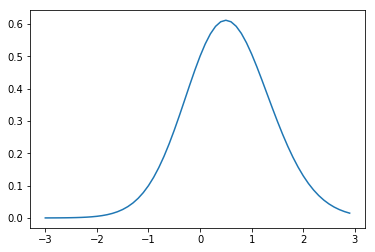

In [21]:
import matplotlib.pyplot as plt

t = np.arange(-3.0, 3.0, 0.1)

plt.plot(t, np.exp(-t**2/2)*(1/(1+np.exp(-1.62434536*t))))

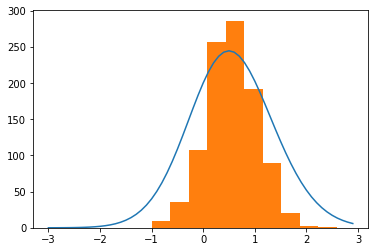

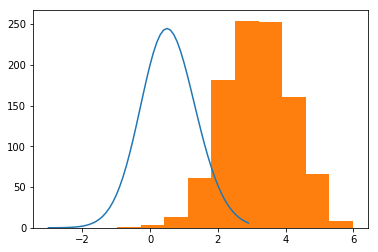

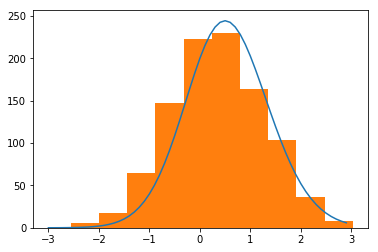

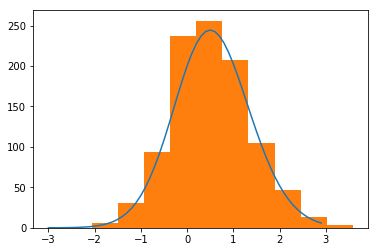

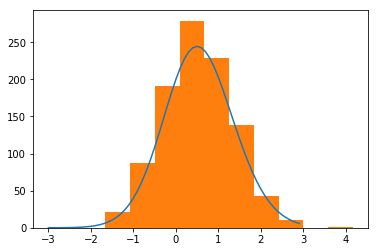

In [33]:
for i in range(5):
    plt.plot(t,400*np.exp(-t**2/2)*(1/(1+np.exp(-1.62434536*t))))
    plt.hist(samples_list[i,:,0])
    plt.show()

In [34]:
basic = make_mala_agent()
normal_samples = redraw_samples(basic,1000)

Drawing sample 1
Drawing sample 2
Drawing sample 3
Drawing sample 4
Drawing sample 5
Drawing sample 6
Drawing sample 7
Drawing sample 8
Drawing sample 9
Drawing sample 10
Drawing sample 11
Drawing sample 12
Drawing sample 13
Drawing sample 14
Drawing sample 15
Drawing sample 16
Drawing sample 17
Drawing sample 18
Drawing sample 19
Drawing sample 20
Drawing sample 21
Drawing sample 22
Drawing sample 23
Drawing sample 24
Drawing sample 25
Drawing sample 26
Drawing sample 27
Drawing sample 28
Drawing sample 29
Drawing sample 30
Drawing sample 31
Drawing sample 32
Drawing sample 33
Drawing sample 34
Drawing sample 35
Drawing sample 36
Drawing sample 37
Drawing sample 38
Drawing sample 39
Drawing sample 40
Drawing sample 41
Drawing sample 42
Drawing sample 43
Drawing sample 44
Drawing sample 45
Drawing sample 46
Drawing sample 47
Drawing sample 48
Drawing sample 49
Drawing sample 50
Drawing sample 51
Drawing sample 52
Drawing sample 53
Drawing sample 54
Drawing sample 55
Drawing sample 56
D

Drawing sample 438
Drawing sample 439
Drawing sample 440
Drawing sample 441
Drawing sample 442
Drawing sample 443
Drawing sample 444
Drawing sample 445
Drawing sample 446
Drawing sample 447
Drawing sample 448
Drawing sample 449
Drawing sample 450
Drawing sample 451
Drawing sample 452
Drawing sample 453
Drawing sample 454
Drawing sample 455
Drawing sample 456
Drawing sample 457
Drawing sample 458
Drawing sample 459
Drawing sample 460
Drawing sample 461
Drawing sample 462
Drawing sample 463
Drawing sample 464
Drawing sample 465
Drawing sample 466
Drawing sample 467
Drawing sample 468
Drawing sample 469
Drawing sample 470
Drawing sample 471
Drawing sample 472
Drawing sample 473
Drawing sample 474
Drawing sample 475
Drawing sample 476
Drawing sample 477
Drawing sample 478
Drawing sample 479
Drawing sample 480
Drawing sample 481
Drawing sample 482
Drawing sample 483
Drawing sample 484
Drawing sample 485
Drawing sample 486
Drawing sample 487
Drawing sample 488
Drawing sample 489
Drawing samp

Drawing sample 870
Drawing sample 871
Drawing sample 872
Drawing sample 873
Drawing sample 874
Drawing sample 875
Drawing sample 876
Drawing sample 877
Drawing sample 878
Drawing sample 879
Drawing sample 880
Drawing sample 881
Drawing sample 882
Drawing sample 883
Drawing sample 884
Drawing sample 885
Drawing sample 886
Drawing sample 887
Drawing sample 888
Drawing sample 889
Drawing sample 890
Drawing sample 891
Drawing sample 892
Drawing sample 893
Drawing sample 894
Drawing sample 895
Drawing sample 896
Drawing sample 897
Drawing sample 898
Drawing sample 899
Drawing sample 900
Drawing sample 901
Drawing sample 902
Drawing sample 903
Drawing sample 904
Drawing sample 905
Drawing sample 906
Drawing sample 907
Drawing sample 908
Drawing sample 909
Drawing sample 910
Drawing sample 911
Drawing sample 912
Drawing sample 913
Drawing sample 914
Drawing sample 915
Drawing sample 916
Drawing sample 917
Drawing sample 918
Drawing sample 919
Drawing sample 920
Drawing sample 921
Drawing samp

(array([  8.,  31.,  75., 150., 252., 203., 152.,  83.,  36.,  10.]),
 array([-1.721301  , -1.37431393, -1.02732685, -0.68033978, -0.33335271,
         0.01363436,  0.36062143,  0.7076085 ,  1.05459557,  1.40158264,
         1.74856972]),
 <a list of 10 Patch objects>)

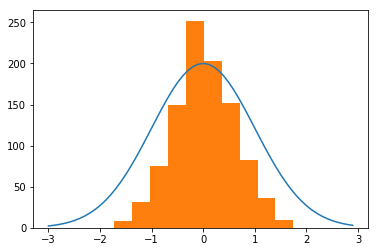

In [38]:
plt.plot(t,200*np.exp(-t**2/2))
plt.hist(normal_samples[:,0])

In [11]:
def mala_normal(x=0,step_size=0.01,num_steps=1000, verbosity=0):
    for t in range(num_steps):
        noise = np.random.randn()
        scaled_noise = np.sqrt(2*step_size) * noise
        z = x - step_size*x + scaled_noise
        #scaled_noise
        p = np.exp(-(z**2)/2+(x**2)/2+((x-z-step_size*z)**2)/(4*step_size)-(noise**2)/2)
        x = z if np.random.random()<p else x
        printv((x,p),verbosity,1)
    return x

def mala_normal2(x=0,step_size=0.01,num_steps=1000):
    for t in range(num_steps):
        noise = np.random.randn()
        scaled_noise = np.sqrt(2*step_size) * noise
        scale = 0.5
        z = x - scale*step_size*x + scaled_noise
        #scaled_noise
        p = np.exp(-z**2*0.5*scale+x**2*0.5*scale+((x-z+scale*step_size*z)**2)/(4*step_size)-(noise)**2/2)
        x = z if np.random.random()<p else x
    return x

In [12]:
#normal_samples2 = [mala_normal(step_size=0.001,num_steps=100000) for t in range(100)]
normal_samples2 = [mala_normal(x=0,step_size=0.1,num_steps=1000) for t in range(1000)]

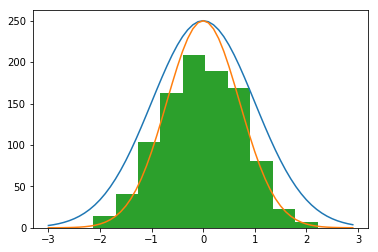

0.5929747504923824

In [13]:
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,250*np.exp(-t**2/2))
plt.plot(t,250*np.exp(-t**2))
plt.hist(normal_samples2)
plt.show()
np.sum(np.power(normal_samples2,2))/1000

In [78]:
normal_samples22 = [mala_normal2(x=0,step_size=0.01,num_steps=1000) for t in range(1000)]

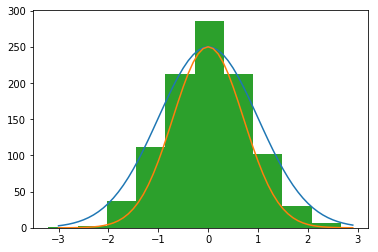

(-3.2029974213616397, 2.6630162674680995)

In [81]:

t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,250*np.exp(-t**2/2))
plt.plot(t,250*np.exp(-t**2))
plt.hist(normal_samples22)
plt.show()
(min(normal_samples22), max(normal_samples22))

In [ ]:
normal_samples3 = [np.random.randn() for t in range(500)]
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,100*np.exp(-t**2/2))
plt.hist(normal_samples3)
plt.show()

(array([100.,  96., 104.,  97.,  95.,  99., 101.,  95.,  97., 116.]),
 array([0.001597  , 0.10132025, 0.2010435 , 0.30076676, 0.40049001,
        0.50021326, 0.59993651, 0.69965976, 0.79938301, 0.89910626,
        0.99882951]),
 <a list of 10 Patch objects>)

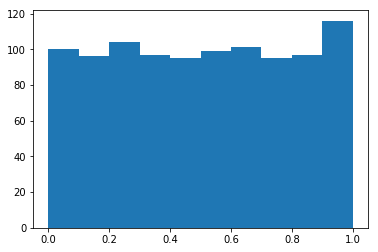

In [38]:
unif_samples = [np.random.random() for t in range(1000)]
plt.hist(unif_samples)

In [51]:
def mala_test2(x=0,step_size=0.01,num_steps=1000):
    for t in range(num_steps):
        noise = np.random.randn()
        scaled_noise = np.sqrt(2*step_size) * noise
        z = x - step_size*1.5*np.sqrt(np.abs(x))*np.sign(x) + scaled_noise
        #scaled_noise
        p = np.exp(-np.abs(z)**1.5+np.abs(x)**1.5+(x-z+step_size*1.5*np.sqrt(np.abs(z))*np.sign(z))**2/(4*step_size)-(noise)**2/2)
        x = z if np.random.random()<p else x
    return x

In [54]:
test2 = [mala_test2(x=0,step_size=0.01,num_steps=1000) for t in range(1000)]

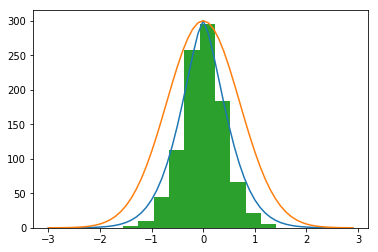

In [58]:
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,300*np.exp(-np.abs(t)**1.5*2))
plt.plot(t,300*np.exp(-t**2))
plt.hist(test2)
plt.show()

In [91]:
mala_normal(x=0,step_size=0.1,num_steps=1000, verbosity=1)

(0.7866569423454293, 0.5469715896909595)
(0.7866569423454293, 0.3485376477350185)
(0.6755399321422417, 1.1716500698932582)
(0.9367384124981939, 0.6632544761379131)
(1.3129456949349048, 0.43815223706456224)
(1.3756446464266823, 0.8484386504059658)
(1.1431717653916718, 1.769890349713403)
(1.1431717653916718, 0.1284698329610172)
(1.2018237510146215, 0.8745024549804663)
(1.2018237510146215, 0.22189592087947496)
(1.2018237510146215, 0.15733630271403842)
(0.38810531804191073, 3.530398400277201)
(0.2482580094058891, 1.0906445548450296)
(0.2482580094058891, 0.35821159958955723)
(-0.07921801263648007, 1.0554557161167928)
(-0.20643387547834285, 0.9651893636490018)
(-0.3372137882238937, 0.933027373653171)
(-0.3372137882238937, 0.6458919778859128)
(-0.35472021036097395, 0.9882590132288406)
(-0.7242349828287031, 0.6779222754134115)
(-0.29272789155450185, 1.5339652117555784)
(0.313730362512889, 0.9876580999348794)
(0.313730362512889, 0.6939408159731613)
(-0.258145976887076, 1.031477984492912)
(-0.28

1.1429397178444807

In [6]:
def langevin_normal(x=0,step_size=0.01,num_steps=1000, verbosity=0):
    for t in range(num_steps):
        noise = np.random.randn()
        scaled_noise = np.sqrt(2*step_size) * noise
        x = x - step_size*x + scaled_noise
        #scaled_noise
        #p = np.exp(-(z**2)/2+(x**2)/2+((x-z+step_size*z)**2)/(4*step_size)-(noise**2)/2)
        #x = z if np.random.random()<p else x
        printv(x,verbosity,1)
    return x

In [ ]:
lgv_samples = [langevin_normal(x=0,step_size=0.01,
                               num_steps=1000, verbosity=0) for _ in range(1000)]


(array([  5.,  22.,  98., 201., 267., 226., 126.,  37.,  15.,   3.]),
 array([-3.25451389, -2.55872319, -1.86293249, -1.16714179, -0.47135109,
         0.22443961,  0.92023031,  1.61602101,  2.31181172,  3.00760242,
         3.70339312]),
 <a list of 10 Patch objects>)

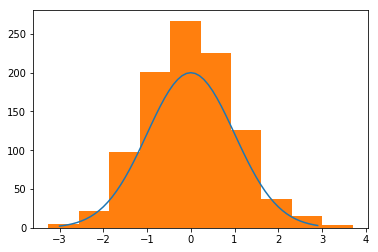

In [10]:
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,200*np.exp(-t**2/2))
plt.hist(lgv_samples)